In [308]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [309]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

In [310]:
filepath = "/content/drive/MyDrive/pet_disease_dataset_v3.csv"

Cleaning dataset

In [311]:
# Load dataset
df = pd.read_csv(filepath)


In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Animal_Type       278 non-null    object 
 1   Breed             278 non-null    object 
 2   Age               278 non-null    int64  
 3   Gender            278 non-null    object 
 4   Weight            278 non-null    float64
 5   Symptom_1         278 non-null    object 
 6   Symptom_2         278 non-null    object 
 7   Symptom_3         278 non-null    object 
 8   Symptom_4         278 non-null    object 
 9   Duration          278 non-null    object 
 10  Body_Temperature  278 non-null    object 
 11  Heart_Rate        278 non-null    int64  
 12  Disease_Category  278 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 28.4+ KB


In [313]:
nan_count = df.isnull().sum().sum()
print('Number of NaN values:', nan_count)

Number of NaN values: 0


In [314]:
# Dropping rows with missing values
df = df.dropna()
nan_count = df.isnull().sum().sum()
print('Number of NaN values:', nan_count)

Number of NaN values: 0


Data visualization

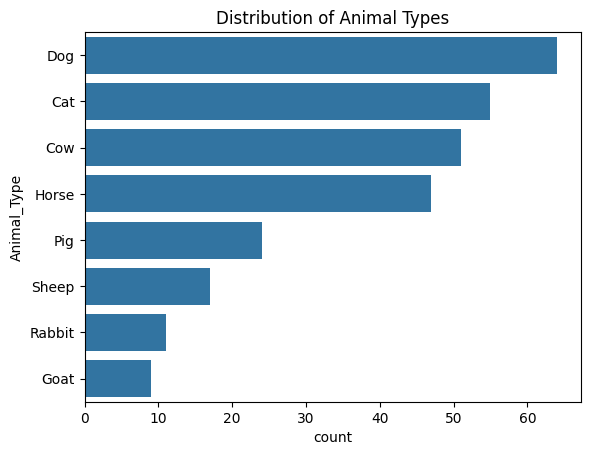

In [315]:
# Distribution of animals
sns.countplot(data=df, y='Animal_Type', order=df['Animal_Type'].value_counts().index)
plt.title('Distribution of Animal Types')
plt.show()

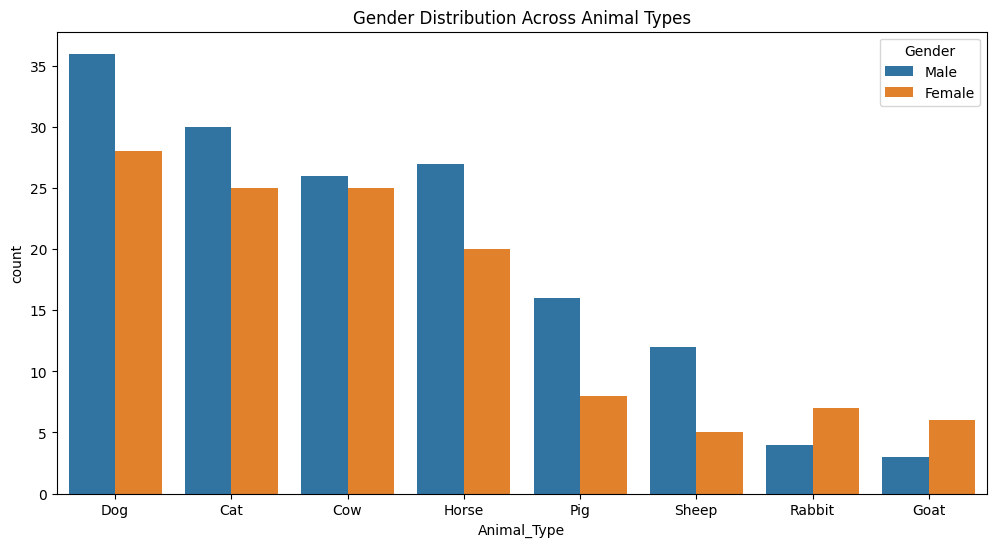

In [316]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Animal_Type', hue='Gender', order=df['Animal_Type'].value_counts().index)
plt.title('Gender Distribution Across Animal Types')
plt.show()

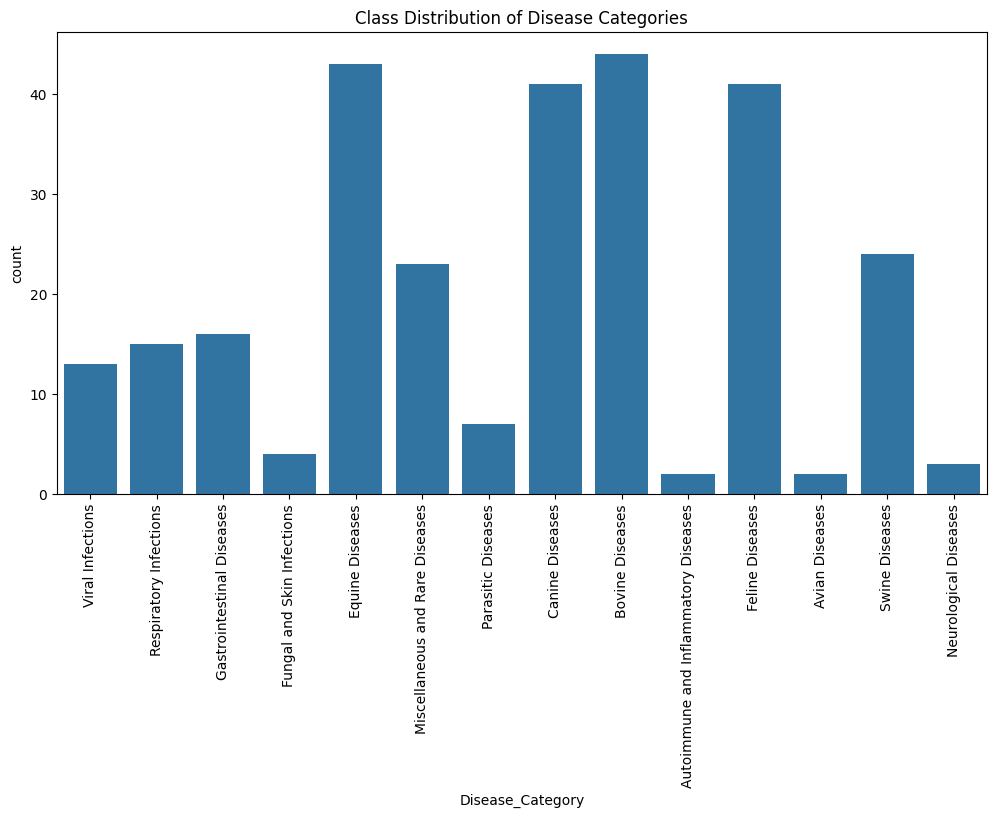

In [317]:
# Check class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=df['Disease_Category'])
plt.xticks(rotation=90)
plt.title("Class Distribution of Disease Categories")
plt.show()


Preprocessing

In [318]:
# Create 'Duration_Num' and convert to days
df['Duration_Num'] = df['Duration'].str.extract('(\d+)').astype(float)

# If the 'Duration' contains 'week', multiply the 'Duration_Num' by 7 to convert to days
df.loc[df['Duration'].str.contains('week', case=False, na=False), 'Duration_Num'] *= 7

# Drop the original 'Duration' column
df.drop(columns=['Duration'], inplace=True)


In [319]:
# Temperature conversion
df['Body_Temperature'] = df['Body_Temperature'].astype(str).str.replace('°C', '', regex=False).astype(float)

In [320]:
df.head()

,Animal_Type,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Body_Temperature,Heart_Rate,Disease_Category,Duration_Num
0,Dog,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,39.5,120,Viral Infections,3.0
1,Cat,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,38.9,150,Respiratory Infections,7.0
2,Cow,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,40.1,90,Viral Infections,5.0
3,Dog,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,39.2,130,Gastrointestinal Diseases,2.0
4,Cat,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,38.7,160,Fungal and Skin Infections,14.0


In [321]:
# Encode categorical variables using appropriate encoding
label_encoders = {}

# Label encode Animal Type, Gender, and Disease Prediction (no inherent order)
for col in ['Animal_Type', 'Gender', 'Disease_Category']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-hot encode Breed and Symptoms (these are categorical without order)
df = pd.get_dummies(df, columns=['Breed', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4'], drop_first=True)


In [322]:
# Normalize numerical features
scaler = StandardScaler()
df[['Age', 'Weight', 'Body_Temperature', 'Heart_Rate']] = scaler.fit_transform(df[['Age', 'Weight', 'Body_Temperature', 'Heart_Rate']])


# No scaling for Duration_Num: It's already a meaningful numeric feature representing days, so we leave it as is.

# Scaling is applied to numerical features like Age, Weight, Body_Temperature, and Heart_Rate: These values vary on different scales and need to be normalized for better model performance.

In [323]:
# Split dataset into training and testing sets
X = df.drop(columns=['Disease_Category'])
y = df['Disease_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model training

In [324]:
# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate models
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Model Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

evaluate_model(rf_model, "RandomForest")
evaluate_model(xgb_model, "XGBoost")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:16:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



RandomForest Model Performance:
Accuracy: 0.7321428571428571
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.83      1.00      0.91        10
           3       0.56      0.83      0.67         6
           4       0.89      1.00      0.94         8
           5       0.89      1.00      0.94         8
           6       0.00      0.00      0.00         0
           7       0.50      0.33      0.40         3
           8       0.80      0.40      0.53        10
           9       0.00      0.00      0.00         1
          10       1.00      0.50      0.67         2
          11       1.00      0.50      0.67         4
          12       0.33      1.00      0.50         2
          13       0.00      0.00      0.00         1

    accuracy                           0.73        56
   macro avg       0.52      0.51      0.48        56
weighted avg       0.75      0.73      0.71        56


XGBoost Model Pe

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_